# Tutorial on how to fit emission line and use IFU data - KMOS/SINFONI/JWST etc

Here I am going to go through basic of analysing IFU data and fitting emission lines. First, in order to quickly look at IFU cubes, I recommend QFits. https://www.mpe.mpg.de/~ott/QFitsView/. In this example, I got some KMOS observations of a galaxy from the KLEVER survey that we can use to fit: Halpha, [NII], [SII], [OIII] and Hbeta. 

To read more about Integral Field Spectroscopy, I recommend section 2.2 of my thesis: http://etheses.dur.ac.uk/13311/1/Thesis_cor_mk_II.pdf?DDD25+ or from Chris Harrison; Chapter 2. http://etheses.dur.ac.uk/10744/1/cmh_thesis.pdf?DDD25+

Also it is worth going through fitting models with emcee - https://emcee.readthedocs.io/en/stable/

## Fitting Halpha of already extracted spectrum - the basics

We will first focus on fitting a Halpha spectrum of an objects called cdfs 38 from KASHz survey. It is an type-2 AGN but without any signs of outflow or by definition, broad line region. I have already extracted the spectrum from the KMOS cube. Once we learn how to fit a spectrum, we can fit a cube next. 

Lets start with importing basic libraries. This is a start of every code I write. 

In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy.optimize import curve_fit

import emcee
import corner 

from os.path import exists
nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23

Ken98= (4.5*10**-44)
Conversion2Chabrier=1.7 # Also Madau
Calzetti12= 2.8*10**-44
arrow = u'$\u2193$' 


PATH='/Users/jansen/My Drive/Astro/'


First we load the spectrum that is in the tutorial folder. The spectrum was saved using np.savetxt and contains following rows: 
1) observed wavelength (in microns)
2) flux density - due to some legacy reasons, the spectrum is divided by 1e-13. This will only matter when calculating the integrated fluxes. 
3) std on the spectrum - (this is the same error on each pixel).
4) Mask 0 Masking bad pixels due to inperfect subtraction of the sky - this will be further discussed during extraction of the spectrum from the cube

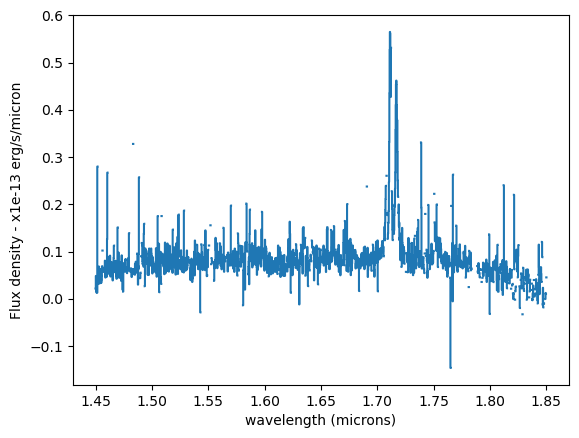

In [2]:
z=1.607
D1_spec = np.loadtxt('/Users/jansen/My Drive/MyPython/Qubespec/QubeSpec/IFS_tutorial/cdfs_38_H_inner_1Dspectrum.txt')
wavem = D1_spec[0,:]
error = D1_spec[2,:]
fluxm = np.ma.array(data=D1_spec[1,:], mask = D1_spec[3,:])

# Lets quickly plot the spectrum
plt.figure()
plt.plot( wavem, fluxm, drawstyle='steps-mid')
plt.xlabel('wavelength (microns)')
plt.ylabel('Flux density - x1e-13 erg/s/micron')

plt.show()


The redshit of this galaxy is z=1.60. The restframe wavelength of the Halpha line is 656.2 nm (6562 angstroms), so for z=1.60 galaxy we we expect this line at observed wavelength of 1.71 microns. Lets zoom in around that spectrum

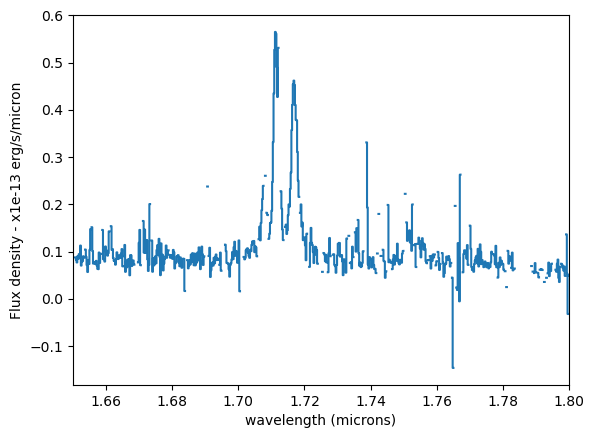

In [3]:
plt.figure()
plt.plot( wavem, fluxm, drawstyle='steps-mid')
plt.xlabel('wavelength (microns)')
plt.ylabel('Flux density - x1e-13 erg/s/micron')
plt.xlim(1.65,1.8)
plt.show()

We can see a very bright detection of narrow Halpha, but there is also a fainter line right next to it at 1.71 microns. This is the [NII] line and it is a doublet - There is one at restframe 6583 and 6548 angstroms. When fitting the Halpha, we wil have to fit the [NII] doublet as well. Furthermore, we will have to model the [SII] doublet 6731 and 6716 angstroms. The [SII] doublet is incredibly faint, and is rarely detected at high redshift. However, it is incredibly useful doublet that can be used to estimated the electron density of the ionised gas. 

So in summary we will be fitting the following models: 
1) narrow Halpha - single Gaussian
2) [NII] doublet - one gaussian components for each of the line in the doublet
3) [SII] doublet - one gaussian components for each of the line in the doublet
4) Continuum - We need to fit the continuum. KMOS and SINFONI are not very sensitive to the features of the continuum hence fitting a line with gradient and normalization is enough. For high SNR data (maybe from JWST?) or local galaxies we would have to fit ppxf models - I have never done it though. 

However, we do not need to fit 3 parameters for each gaussian (peak, location and width) as we can make some assumptions and use some physics.
1) First of all we will assume that all of these emission lines are coming from the same gas - hence they will have the same redshift
2) Because they are coming from the same gas, they have the samw width - sigma of the line
3) The [NII] has fixed line ratio between the two lines - the [NII]6548 line has 1/3 of the flux of the [NII]6583 line. Since the width of these lines is the same, we can say that the ratio of the peaks of these two lines is 3. 

This drastically reduces the amount of free parameters - from 17 to 8. 

In order to fit these models we will use emcee. I enjoy this method as it takes care of the errors on each parameter and is more robust searching the parameter space. 

In the next few sections we will setup the model and then fit it using emcee. Once we understand this, we can start using my code that incorporates all of this.  

In [4]:
# Defining the model for fitting emission lines around Halpha including of course Halpha itself. 
# Setting up a single Gaussian - will be used later 
def gauss(x, k, mu,sig):

    expo= -((x-mu)**2)/(2*sig*sig)
    
    y= k* e**expo
    
    return y

# Setting up the Halpha model:
# First we calculate the observed frame wavelengths of the lines
# Next: We input the line width (Nar_fwhm) as a velocity FWHM - we need to convert it to width (sigma) in wavelengths units
# The velocity width of the line can be calculated as: Vel = (delta wavelength)/wavelength * speed of light
# Then we calculate the individfual components - Halpha, [NII] and [SII]
# Finally we add all of them together
def Halpha(x, z, cont,cont_grad,  Hal_peak, NII_peak, Nar_fwhm, SII_rpk, SII_bpk):
    Hal_wv = 6562.8*(1+z)/1e4    
    NII_r = 6583.*(1+z)/1e4
    NII_b = 6548.*(1+z)/1e4
    SII_r = 6731.*(1+z)/1e4   
    SII_b = 6716.*(1+z)/1e4   
    
    Nar_sigma_hal = Nar_fwhm/3e5*Hal_wv/2.35482
    Nar_sigma_niir = Nar_fwhm/3e5*NII_r/2.35482
    Nar_sigma_niib = Nar_fwhm/3e5*NII_b/2.35482
    Nar_sigma_sii = Nar_fwhm/3e5*SII_b/2.35482
    
    Hal_nar = gauss(x, Hal_peak, Hal_wv, Nar_sigma_hal)

    NII_nar_r = gauss(x, NII_peak, NII_r, Nar_sigma_niir)
    NII_nar_b = gauss(x, NII_peak/3, NII_b, Nar_sigma_niib)
    
    SII_rg = gauss(x, SII_rpk, SII_r, Nar_sigma_sii)
    SII_bg = gauss(x, SII_bpk, SII_b, Nar_sigma_sii)
    
    return cont+x*cont_grad+Hal_nar+NII_nar_r+NII_nar_b + SII_rg + SII_bg

# The log likelihood of the model is just a chi2 value
def log_likelihood_Halpha(theta, x, y, yerr):
    
    model = Halpha(x,*theta)
    sigma2 = yerr*yerr
    return -0.5 * np.sum((y - model) ** 2 / sigma2) 

# Here we set the priors. I usually go for a flat prior on my paramters. I give them a resonable boundries. Notice that my 
# redhisft range is very narrow. This is due to poor SNR of my lines, it makes it easier not to search every noise spike
def log_prior_Halpha(theta, zguess):
    z, cont,cont_grad, Hal_peak, NII_peak, Nar_fwhm,  SII_rpk, SII_bpk = theta
    if (zguess-0.05) < z < (zguess+0.05) and 0 < cont<1 and 0<Hal_peak<2 and 0< NII_peak<2 \
        and 150 < Nar_fwhm<900 and -1 <cont_grad<1 and 0<SII_bpk<1 and 0<SII_rpk<1:
            return 0.0
    
    return -np.inf

# The overall log probability function that encompases all of it. 
def log_probability_Halpha(theta, x, y, yerr, zguess):
    lp = log_prior_Halpha(theta,zguess)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_Halpha(theta, x, y, yerr)

Next we will prep the data for fitting:
1) will only include channels (data) that was not masked. 

2)  We are not really interested in fitting the whole spectral window. We are only interested in the range our the spectral line. I like to go +- 300 angstroms around the line.

3) Lastly, we need to find the value of the peak of the line - we will use this when creating initial conditions. 

In [5]:
flux = fluxm.data[np.invert(fluxm.mask)]
wave = wavem[np.invert(fluxm.mask)]
    
fit_loc = np.where((wave>(6562.8-300)*(1+z)/1e4)&(wave<(6562.8+300)*(1+z)/1e4))[0]
       
sel=  np.where(((wave<(6562.8+20)*(1+z)/1e4))& (wave>(6562.8-20)*(1+z)/1e4))[0]
flux_zoom = flux[sel]
wave_zoom = wave[sel]
    
peak_loc = np.ma.argmax(flux_zoom)
peak = np.ma.max(flux_zoom)

ok so now is the time to do the actual fitting and deal with the results:

In [ ]:
# Set number of iterations of the mcmc chain - 5000 is good for now, I will go for 10 000 in the final science
N = 5000

# We need to setup the starting positions of the 32 walkers - 32 mcmc chains each with starting position
# The starting position for the parameters:
# Redshift - z - just our best guess for the redshift or if we know it from different data
# continuum - a - just mean of the flux - essentially the normalization
# continuum slope - 0.01
# halpha gaussian peak - half of the peak defined above
# [NII] gaussian peak - 1/4 of the peak defined above
# FWHM width of the emission lines - lets start with 400 km/s
# [SII] red gaussian peak - 1/6 of the peak defined above
# [SII] blue gaussian peak - 1/6 of the peak defined above
pos = np.array([z,np.mean(flux),0.01, peak/2, peak/4, 400.,peak/6, peak/6 ])+ 1e-4 * np.random.randn(32, 8)
nwalkers, ndim = pos.shape
    
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_Halpha, args=(wave[fit_loc], flux[fit_loc], error[fit_loc],z))
    
sampler.run_mcmc(pos, N, progress=True);

# Extract the chains - burn the first 25% of the chain 
flat_samples = sampler.get_chain(discard=int(0.25*N), thin=15, flat=True)

# Next save the chains as a dictionary so you can easily call them by name, rather than some index in the 2D array - just for comfort
labels=('z', 'cont','cont_grad', 'Hal_peak', 'NII_peak', 'Nar_fwhm', 'SIIr_peak', 'SIIb_peak')

res = {'name': 'Halpha'} # define the disctionary and put a name of the model into it. 
for i in range(len(labels)):
    res[labels[i]] = flat_samples[:,i]
    



        

 83%|███████████████████████████████▌      | 4145/5000 [00:16<00:03, 228.45it/s]

Lets quickly check the corner plot for these chains

In [ ]:
import corner
fig = corner.corner(
            flat_samples, 
            labels=labels,
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
            title_kwargs={"fontsize": 12})
plt.show()

Now that we have the chains, it is time to get the best parameters and errors that we can report and also use to plot the model. For this, I have written a function called prop_calc. This function calculates the errors and 68 % confidence interval errors and saves them as a new object. Furthermore, it also creates an array called popt (inside the pp dictionary) that contains all of the parameters for plotting. 

In [ ]:
def prop_calc(results):  
    labels = list(results.keys())[1:]
    res_plt = []
    res_dict = {'name': results['name']}
    for lbl in labels:
        
        array = results[lbl]
        
        p50,p16,p84 = np.percentile(array, (50,16,84))
        p16 = p50-p16
        p84 = p84-p50
        
        res_plt.append(p50)
        res_dict[lbl] = np.array([p50,p16,p84])
        
    res_dict['popt'] = res_plt
    return res_dict

pp = prop_calc(res)
print(pp)

And now lets plot the model over the data. 

In [ ]:
plt.figure()
plt.plot( wave, flux, drawstyle='steps-mid')
plt.xlabel('wavelength (microns)')
plt.ylabel('Flux density - x 1e-13 erg/s/micron')
plt.plot(wave, Halpha(wave, *pp['popt']))

plt.xlim(1.65,1.8)
plt.show()

### Calculating SNR

we will now calculate the SNR of the line. This can be tricky for emission line, as we need to take into consideration not just the peak channel, but also other inside the emission line profile.

The equation we use is as follows: 
\begin{equation}
SNR = \frac{1}{\sqrt{n}} \sum \frac{\rm flux \space  density}{\rm error \space per \space channel} 
\end{equation}

where the flux is the the flux density values at each channel within certain velocity/wavelength range, sigma is the uncertanties on the flux densities (error) and the n is the number of channels across the range of the emission line. 

In [ ]:
wv0 = 6563*(1+pp['z'][0])/1e4
fwhm = pp['Nar_fwhm'][0]/3e5*wv0
eml_model = gauss(wave,pp['Hal_peak'][0], wv0 , fwhm/2.35) 

use = np.where( ((wv0-fwhm)<wave) & (wave< (wv0+fwhm)))[0]
flux_sel = eml_model[use]

n = len(use)
SNR = (sum(flux_sel)/np.sqrt(n)) * (1./error[0])
print('SNR of the Halpha line :', SNR)

the alternative way is to calculate it dirrectly from the MCMC as integrated flux/ error on the integrated flux. See how to caluclate the integrated flux below!\frac{1}{\sqrt{n}}


## Estimating the integrated flux of the line

It is now time to calculate all the properties of the line. The way we setup the fitting, we imddiatly have the emission line width (as FWHM in velocity space), redshift (location of the line). We now need to estimate the total integrated flux of the line. Luckily, for this we just need to integrate the flux density (flux per unit of wavelength) to get total flux. 

Unlike with SNR, the equation for flux is not dependant on the number of channels so we integrate the gaussian across all the channels (The Gaussian far away from our line is going to be 0, or very close to it). 

In [ ]:
import scipy.integrate as scpi # we will use scipy's integrate simpsons function to do this
            
wv0 = 6563*(1+pp['z'][0])/1e4
fwhm = pp['Nar_fwhm'][0]/3e5*wv0
eml_model = gauss(wave,pp['Hal_peak'][0], wv0 , fwhm/2.35) 

Flux = scpi.simps(eml_model, wave)*1e-13 # Remember when I said that we normalize the spectrum earlier? That where the 1e-13 factor comes in
print('Flux of the line is: ', Flux, 'ergs/s/cm-2')

In order to get the error on the flux, ideally we want to calculate the value above for each value in the chains, and then estimate the 68% confindence interval, like with the parameters above.  

In [ ]:
def flux_mcmc(chains):  
    Nchain = len(chains['z'])
    itere = np.arange(Nchain/2,Nchain,1, dtype=int)
    Fluxes= []
    for i in itere:
        
        
        wv0 = 6563*(1+chains['z'][i])/1e4
        fwhm = chains['Nar_fwhm'][i]/3e5*wv0
        eml_model = gauss(wave,chains['Hal_peak'][i], wv0 , fwhm/2.35)       
        Flux = scpi.simps(eml_model, wave)*1e-13 # Remember when I said that we normalize the spectrum earlier? That where the 1e-13 factor comes in
        
        Fluxes.append(Flux)
        
        return np.percentile(Fluxes, (50,16,84))
        
flux_including_percintiles = flux_mcmc(res)